# SNN Playground


In [1]:
import sys
import snntorch as snn
from snntorch import spikeplot as split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Linear, Module
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import itertools

import rsatoolbox as rsa
from rsatoolbox.inference import evaluate as eval
from rsatoolbox.inference.bootstrap import (bootstrap_sample,
                                            bootstrap_sample_pattern,
                                            bootstrap_sample_rdm)
from rsatoolbox.util.inference_util import all_tests, get_errorbars
from rsatoolbox.util.rdm_utils import batch_to_vectors
from rsatoolbox.util.inference_util import all_tests, get_errorbars
from rsatoolbox.util.rdm_utils import batch_to_vectors

print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Numpy version', np.__version__)
print("env path: ", sys.executable) 

#[+] check to see if gpu is available, else use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
print('Using device: ',device)
for i in range(torch.cuda.device_count()): print('       -->',i,':', torch.cuda.get_device_name(i))

System Version: 3.9.18 (main, Sep 11 2023, 13:30:38) [MSC v.1916 64 bit (AMD64)]
PyTorch version 2.3.1+cu118
Numpy version 1.26.4
env path:  c:\Users\richa\OneDrive\Dugree\Project\cuda\Scripts\python.exe
Using device:  cuda
       --> 0 : NVIDIA GeForce RTX 2070


## DataLoading MNIST

In [2]:
batch_size= 128
data_path= r'./data'
dtype= torch.float

# Create the transoform for MNIST dataset to make sure its 28x28, grayscale, a tensor, and vals normalized to fall between 0 and 1
transform= transforms.Compose([
    transforms.Resize((28,28)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0,), (1,)),])

# Automatically downloads and splits the MNIST dataset
mnist_train = datasets.MNIST(data_path, train= True , download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train= False, download=True, transform=transform)

#create DataLoaders
train_loader= DataLoader(mnist_train , batch_size= batch_size, shuffle=True, drop_last=True)
test_loader= DataLoader(mnist_test , batch_size= batch_size, shuffle=True, drop_last=True)

# Construct a Fully Connected SNN Architecture

In [3]:
# Number of inputs should match number of pixels in the MNIST img
num_inputs= 28*28  #= 784

# Hidden layer is however big you want as long as it fits in your GPU
num_hidden= 1000

# One output neuron for each of the 10 MNIST digits
num_outputs= 10

# 25 time steps is a quick simulation by default, reduce to 5 to match the layers of the CNN 
num_steps= 5

# Rate of decay
beta= 0.95

In [4]:
class Snn(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers before defining the forward function
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)

        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)
        

    def forward(self, x):
        # init hidden states at t=0, mem is membrane potential
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        
        # [+] Record the hidden layer
        spk1_rec = []
        mem1_rec = []

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            # x.shape: torch.Size([128, 784]) -> 128=batch_size, 784= 28x28 img; x is a batch of 128 images

            # cur1 , spk1, mem1 shape:  torch.Size([128, 1000]) torch.Size([128, 1000]) torch.Size([128, 1000])
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            
            # cur2 , spk2, mem2 shape:  torch.Size([128, 10]) torch.Size([128, 10]) torch.Size([128, 10])
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            
            # [+] store hidden layer in list
            spk1_rec.append(spk1)
            mem1_rec.append(mem1)

            # stor final layer in list
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        # rec stack sizes:  torch.Size([25, 128, 10]) torch.Size([25, 128, 10])
        spk_stack, mem_stack= torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)
        spk_stack_hid, mem_stack_hid= torch.stack(spk1_rec, dim=0), torch.stack(mem1_rec, dim=0)

        # The network returns a tensor of spike recordings over time, and a tensor of membrane potential recordnigs over time
        return spk_stack, mem_stack, spk_stack_hid, mem_stack_hid

        
# Load the network onto CUDA if available
snn = Snn().to(device)

## Training

In [5]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(snn.parameters(), lr=5e-4, betas=(0.9, 0.999))

# # 60000 data samples / 128 samples per batch = approx 468 iterations
num_epochs = 2
loss_hist = []
test_loss_hist = []
counter = 0
cntLim= 100
saveMdl= True

# Outer training loop
for epoch in range(num_epochs):
    train_batch = iter(train_loader)

    # Minibatch training loop: each batch will have data which is the 128 samples, and each sample will have target labels (digits 0-9), we load all into cuda
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        #forward pass: we set our network to train mode, and pass the data into it
        snn.train()
        spk_rec, mem_rec, _, _ = snn(data.flatten(1))
        #spk_rec and mem_rec sizes:  torch.Size([25, 128, 10]) 

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        loss_val += loss(spk_rec.sum(0), targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Print train/test loss/accuracy
        if counter % 10 == 0:
            print(f"Iteration: {counter} \t Train Loss: {loss_val.item()}")
        counter += 1

        if counter == cntLim:
            if(saveMdl):
                mdlName= 'snn_mdl_ts'+str(num_steps)+'_epoch'+str(num_epochs)+'.pth'
                torch.save(snn.state_dict(), mdlName)
                print(' -->[+] model saved as', mdlName)
            else: print('   -->[x] no save')
            break

Iteration: 0 	 Train Loss: 2.3025848865509033
Iteration: 10 	 Train Loss: 1.201338529586792
Iteration: 20 	 Train Loss: 0.7840991020202637
Iteration: 30 	 Train Loss: 0.7090553045272827
Iteration: 40 	 Train Loss: 0.5142602920532227
Iteration: 50 	 Train Loss: 0.5549402832984924
Iteration: 60 	 Train Loss: 0.46984219551086426
Iteration: 70 	 Train Loss: 0.499573290348053
Iteration: 80 	 Train Loss: 0.433368980884552
Iteration: 90 	 Train Loss: 0.4596647024154663
 -->[+] model saved as snn_mdl_ts5_epoch2.pth
Iteration: 100 	 Train Loss: 0.477770060300827
Iteration: 110 	 Train Loss: 0.34918591380119324
Iteration: 120 	 Train Loss: 0.34316307306289673
Iteration: 130 	 Train Loss: 0.3775034248828888
Iteration: 140 	 Train Loss: 0.3686288893222809
Iteration: 150 	 Train Loss: 0.44031012058258057
Iteration: 160 	 Train Loss: 0.4504972994327545
Iteration: 170 	 Train Loss: 0.3337744176387787
Iteration: 180 	 Train Loss: 0.3251224160194397
Iteration: 190 	 Train Loss: 0.2854149341583252
Itera

## Test Accuracy

In [6]:
def measure_accuracy(model, dataloader):
  with torch.no_grad():
    model.eval()
    running_length = 0
    running_accuracy = 0

    for data, targets in iter(dataloader):
      # data shape:  torch.Size([128, 1, 28, 28])
      data = data.to(device)
      targets = targets.to(device)

      # flat data shape:  torch.Size([128, 784]) -> a batch of 28x28 imsg is flattened to a batch of 1x784 along dim 1
      data= data.flatten(1)

      # spk_rec, mem_rec = model(data)
      spk_rec, mem_rec, spk_stack_hid, mem_stack_hid = model(data)
      
      spike_count = spk_rec.sum(0)
      _, max_spike = spike_count.max(1)

      # correct classes for one batch
      num_correct = (max_spike == targets).sum()

      # total accuracy
      running_length += len(targets)
      running_accuracy += num_correct
    
    accuracy = (running_accuracy / running_length)

    return accuracy.item(), spk_rec, mem_rec, spk_stack_hid, mem_stack_hid

In [7]:
# Sanity
accuracy, spk_rec, mem_rec, spk_stack_hid, mem_stack_hid= measure_accuracy(snn, test_loader)

# dimensions: [timesteps x batchSize x params]
print('spk_rec: ', spk_rec.shape,'\n', spk_rec[0][0],'\n')
print('mem_rec: ', mem_rec.shape,'\n',mem_rec[0][0],'\n')
print('spk_stack_hid: ', spk_stack_hid.shape,'\n', spk_stack_hid[0][0],'\n')
print('mem_stack_hid: ', mem_stack_hid.shape,'\n',mem_stack_hid[0][0],'\n')
print( 'Accuracy: ', accuracy)


spk_rec:  torch.Size([5, 128, 10]) 
 tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], device='cuda:0') 

mem_rec:  torch.Size([5, 128, 10]) 
 tensor([-0.3378, -0.9371, -0.3655, -0.2609, -0.2902,  0.4016,  1.8387, -0.6964,
         0.1424, -0.5629], device='cuda:0') 

spk_stack_hid:  torch.Size([5, 128, 1000]) 
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,

## RSA 

Create the dataset for spikes and membrane potential of the hidden layer to be used for RSA

In [8]:
# [timesteps, batchSize=128, paramCount=1000]
'''
dataset fields and their [correct] types: 
    measurements= measurements, type= numpy.ndarray
    descriptors= {'layer': timeLayerName}, type= dict
    obs_descriptors= {'image': np.arange(measurements.shape[0])}, type= dict
    channel_descriptors= {'channel': np.arange(measurements.shape[1])}) type= dict
'''

snn_spk_datasets= {}
for i, activations in enumerate(spk_stack_hid):
    timeStep= i+1
    timeLayerName= 'timeStep_'+str(timeStep)

    #convert the torch tensor to numpy array to make it work with RSA, but first move it to cpu because its on the GPU
    measurements= activations.cpu().numpy()
    #shape @ each timeStep :  torch.Size([128, 1000]) = batchSize x layerSize

    snn_spk_datasets[timeLayerName] = rsa.data.Dataset(measurements=measurements,
                                            descriptors={'layer': timeLayerName},
                                            obs_descriptors={'image': np.arange(measurements.shape[0])},
                                            channel_descriptors={'channel': np.arange(measurements.shape[1])})
print('\n',snn_spk_datasets)




snn_mem_datasets= {}
for i, activations in enumerate(mem_stack_hid):
    timeStep= i+1
    timeLayerName= 'timeStep_'+str(timeStep)

    #convert the torch tensor to numpy array to make it work with RSA, but first move it to cpu because its on the GPU
    measurements= activations.cpu().numpy()
    #shape @ each timeStep :  torch.Size([128, 1000]) = batchSize x layerSize

    snn_mem_datasets[timeLayerName] = rsa.data.Dataset(measurements=measurements,
                                            descriptors={'layer': timeLayerName},
                                            obs_descriptors={'image': np.arange(measurements.shape[0])},
                                            channel_descriptors={'channel': np.arange(measurements.shape[1])})
print('\n',snn_mem_datasets)



 {'timeStep_1': rsatoolbox.data.Dataset(
measurements = 
[[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]
descriptors = 
{'layer': 'timeStep_1'}
obs_descriptors = 
{'image': array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127])}
channe

### RDMs of SNN Hidden Layer at each timestep

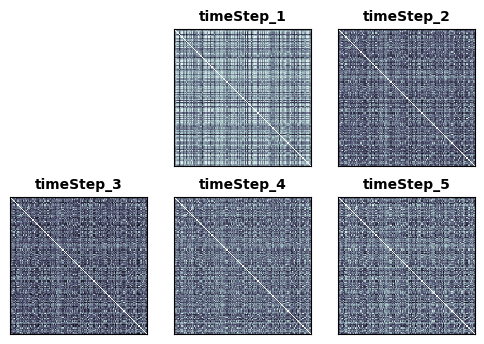

In [9]:

snn_spk_rdms_dict = {}
for layer, dataset in snn_spk_datasets.items():
    snn_spk_rdms_dict[layer] = rsa.rdm.calc_rdm(dataset)

snn_spk_rdms= rsa.rdm.concat(snn_spk_rdms_dict.values())
fig= rsa.vis.rdm_plot.show_rdm(snn_spk_rdms, rdm_descriptor= 'layer')[0]


# same rdms different viz method
# show_rdm_plotly(snn_spk_rdms, rdm_descriptor= 'layer')

In [10]:
# print(snn_spk_rdms_dict.keys())
# print(snn_spk_rdms_dict['timeStep_1'].dissimilarities.shape)
